In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [36]:
district_df = pd.read_csv('data/상권-추정매출_업종재분류_시계열.csv', encoding='cp949')

In [37]:
district_df = district_df.groupby(['상권_코드', '상권_코드_명', '상권_구분_코드_명']).sum().reset_index()

C:\Users\msl06\AppData\Local\Temp\ipykernel_10452\4050025664.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  district_df = district_df.groupby(['상권_코드', '상권_코드_명', '상권_구분_코드_명']).sum().reset_index()


In [26]:
TARGET_DATES = ["2019-Q4"] + [f"{year}-Q{quarter}" for year in range(2020, 2023) for quarter in range(1, 5)]
# 2023년 제외 (문의 결과 집계방식 변화했다고 함)

In [39]:
dist_area = pd.read_csv('data/상권_면적.csv', encoding='cp949') # From QGIS

In [40]:
area_dict = dict(zip(dist_area["TRDAR_CD"], dist_area["면적"]))
district_df["상권_면적"] = district_df["상권_코드"].map(area_dict)

## Preprocessing

### 결측치

In [42]:
has_zeros = district_df[(district_df == 0).any(axis=1)]["상권_코드"].unique()

In [43]:
has_zeros

array([3110013, 3110097, 3110279, 3110321, 3110443, 3110556, 3110705,
       3110761, 3110806, 3110911, 3110993], dtype=int64)

In [44]:
district_df = district_df[~district_df["상권_코드"].isin(has_zeros)]
district_df.set_index("상권_코드", inplace=True)

### 면적당 매출 / 2019-4 대비 비율

In [45]:
X_sales = district_df[TARGET_DATES].copy()
X_sales.head(2)

2019-Q4       2020-Q1       2020-Q2       2020-Q3       2020-Q4  \
상권_코드                                                                           
3110001  1.629469e+09  1.374213e+09  1.775637e+09  1.554979e+09  1.641860e+09   
3110002  1.063425e+10  9.242752e+09  8.292882e+09  8.157527e+09  8.322776e+09   

              2021-Q1       2021-Q2       2021-Q3       2021-Q4       2022-Q1  \
상권_코드                                                                           
3110001  1.425932e+09  1.646886e+09  1.529374e+09  1.703155e+09  1.536460e+09   
3110002  7.998474e+09  7.936060e+09  7.979638e+09  9.209514e+09  8.151600e+09   

              2022-Q2       2022-Q3       2022-Q4  
상권_코드                                              
3110001  1.902487e+09  1.454582e+09  1.691333e+09  
3110002  8.299644e+09  9.302112e+09  8.968987e+09

In [46]:
# 면적
for date in TARGET_DATES:
    X_sales[date] = X_sales[date] / X_sales.index.map(area_dict)

# 비율
col_2019 = X_sales["2019-Q4"].copy()
for date in TARGET_DATES:
    X_sales[date] = X_sales[date] / col_2019

In [47]:
X_sales.describe()

2019-Q4      2020-Q1      2020-Q2      2020-Q3      2020-Q4  \
count   1328.0  1328.000000  1328.000000  1328.000000  1328.000000   
mean       1.0     0.896696     1.000924     0.948569     0.919420   
std        0.0     0.262287     0.575909     0.354765     0.389178   
min        1.0     0.151829     0.150742     0.065046     0.124778   
25%        1.0     0.812631     0.875477     0.819947     0.792551   
50%        1.0     0.892306     0.969276     0.919604     0.877042   
75%        1.0     0.961577     1.060450     1.018286     0.980761   
max        1.0     7.993700    19.140535     7.704753     8.811318   

           2021-Q1      2021-Q2      2021-Q3      2021-Q4      2022-Q1  \
count  1328.000000  1328.000000  1328.000000  1328.000000  1328.000000   
mean      0.851888     0.960665     0.939362     0.980830     0.885308   
std       0.316096     0.415389     0.443389     0.534402     0.373178   
min       0.084089     0.112266     0.100246     0.048966     0.067075   
25%       0.720396     0.797056     0.762923     0.806804     0.720852   
50%       0.822159     0.914894     0.891989     0.922787     0.848476   
75%       0.933389     1.037810     1.021350     1.057333     0.976610   
max       5.818171     7.246193     8.410074    10.750512     6.254853   

           2022-Q2      2022-Q3      2022-Q4  
count  1328.000000  1328.000000  1328.000000  
mean      1.000059     1.001094     0.998348  
std       0.427854     0.543340     0.467002  
min       0.038740     0.055141     0.047922  
25%       0.816897     0.801324     0.810752  
50%       0.949705     0.942955     0.953963  
75%       1.091978     1.082004     1.083373  
max       6.289608     9.223707     8.406981

In [48]:
# log 변환 
X_sales_log = np.log10(X_sales)
X_sales_log.describe()

2019-Q4      2020-Q1      2020-Q2      2020-Q3      2020-Q4  \
count   1328.0  1328.000000  1328.000000  1328.000000  1328.000000   
mean       0.0    -0.057761    -0.018112    -0.040704    -0.056230   
std        0.0     0.093431     0.113502     0.120982     0.124108   
min        0.0    -0.818645    -0.821765    -1.186782    -0.903862   
25%        0.0    -0.090106    -0.057755    -0.086214    -0.100973   
50%        0.0    -0.049486    -0.013553    -0.036399    -0.056979   
75%        0.0    -0.017016     0.025490     0.007870    -0.008437   
max        0.0     0.902748     1.281954     0.886759     0.945041   

           2021-Q1      2021-Q2      2021-Q3      2021-Q4      2022-Q1  \
count  1328.000000  1328.000000  1328.000000  1328.000000  1328.000000   
mean     -0.089894    -0.040265    -0.053885    -0.038025    -0.079782   
std       0.130899     0.134690     0.145907     0.153868     0.153235   
min      -1.075263    -0.949752    -0.998931    -1.310102    -1.173442   
25%      -0.142429    -0.098511    -0.117519    -0.093232    -0.142154   
50%      -0.085044    -0.038629    -0.049640    -0.034899    -0.071360   
75%      -0.029937     0.016118     0.009175     0.024212    -0.010279   
max       0.764787     0.860110     0.924800     1.031429     0.796217   

           2022-Q2      2022-Q3      2022-Q4  
count  1328.000000  1328.000000  1328.000000  
mean     -0.028121    -0.033565    -0.031543  
std       0.159353     0.168757     0.168419  
min      -1.411840    -1.258522    -1.319468  
25%      -0.087833    -0.096192    -0.091112  
50%      -0.022411    -0.025509    -0.020468  
75%       0.038214     0.034229     0.034778  
max       0.798624     0.964905     0.924640

### 이상치 제거

이상치 제거방식 3sigma로 변경 

In [49]:
# Get += 3sig of each column
sig_3 = dict(X_sales_log.mean() + 3 * X_sales_log.std())
sig_m3 = dict(X_sales_log.mean() - 3 * X_sales_log.std())

In [51]:
sig_3

{'2019-Q4': 0.0,
 '2020-Q1': 0.22253184294488795,
 '2020-Q2': 0.32239454199784323,
 '2020-Q3': 0.3222434284617101,
 '2020-Q4': 0.3160926386410033,
 '2021-Q1': 0.30280391621013586,
 '2021-Q2': 0.36380524834074923,
 '2021-Q3': 0.3838370924179933,
 '2021-Q4': 0.423578946598874,
 '2022-Q1': 0.3799235277349392,
 '2022-Q2': 0.4499388418959076,
 '2022-Q3': 0.47270665693248776,
 '2022-Q4': 0.4737139140106641}

In [52]:
sig_m3

{'2019-Q4': 0.0,
 '2020-Q1': -0.3380534136955395,
 '2020-Q2': -0.3586181196229147,
 '2020-Q3': -0.40365101999767,
 '2020-Q4': -0.4285534159756536,
 '2021-Q1': -0.4825918776218215,
 '2021-Q2': -0.44433469104145384,
 '2021-Q3': -0.49160695320949904,
 '2021-Q4': -0.4996284263609662,
 '2022-Q1': -0.5394880188835025,
 '2022-Q2': -0.5061814331533137,
 '2022-Q3': -0.5398360481957918,
 '2022-Q4': -0.5367995001537598}

In [53]:
def find_outlier(row, sig_3, sig_m3):
    for date in TARGET_DATES:
        if row[date] > sig_3[date] or row[date] < sig_m3[date]:
            return True
    return False

In [54]:
X_sales_log["outlier"] = X_sales_log.apply(lambda row: find_outlier(row, sig_3, sig_m3), axis=1)

In [55]:
X_sales_log["outlier"].value_counts()

False    1245
True       83
Name: outlier, dtype: int64

In [56]:
X_sales_processed = X_sales_log[~X_sales_log["outlier"]].drop("outlier", axis=1)

In [58]:
X_sales_processed.describe()  

2019-Q4      2020-Q1      2020-Q2      2020-Q3      2020-Q4  \
count   1245.0  1245.000000  1245.000000  1245.000000  1245.000000   
mean       0.0    -0.056379    -0.017795    -0.041043    -0.058118   
std        0.0     0.065827     0.079432     0.083948     0.081415   
min        0.0    -0.332610    -0.344927    -0.403187    -0.399278   
25%        0.0    -0.087272    -0.055905    -0.082971    -0.099317   
50%        0.0    -0.049396    -0.014171    -0.036369    -0.058040   
75%        0.0    -0.018487     0.024126     0.006623    -0.011617   
max        0.0     0.187702     0.317199     0.291070     0.287928   

           2021-Q1      2021-Q2      2021-Q3      2021-Q4      2022-Q1  \
count  1245.000000  1245.000000  1245.000000  1245.000000  1245.000000   
mean     -0.089471    -0.040428    -0.055629    -0.036550    -0.076701   
std       0.096336     0.095864     0.106640     0.101809     0.108324   
min      -0.467187    -0.368922    -0.439025    -0.455378    -0.508291   
25%      -0.138212    -0.094766    -0.111621    -0.088740    -0.136914   
50%      -0.084893    -0.039283    -0.050318    -0.035140    -0.070245   
75%      -0.033500     0.011620     0.004388     0.018725    -0.013089   
max       0.297234     0.339726     0.382472     0.381400     0.363457   

           2022-Q2      2022-Q3      2022-Q4  
count  1245.000000  1245.000000  1245.000000  
mean     -0.025103    -0.031707    -0.026255  
std       0.109560     0.112774     0.114195  
min      -0.500212    -0.507705    -0.511795  
25%      -0.084067    -0.093005    -0.083473  
50%      -0.023301    -0.025158    -0.019425  
75%       0.035144     0.031164     0.032355  
max       0.424356     0.435690     0.426975

### 스케일링

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sales_processed.T).T
# to dataframe
X_scaled = pd.DataFrame(
    X_scaled, columns=X_sales_processed.columns, index=X_sales_processed.index
)

## Clustering

In [60]:
import time
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [63]:
def plot_scores(X, metric_name='euclidean', seed=0):
    distortions = []
    silhouette = []
    clusters_range = range(2, 13)

    for i in tqdm(clusters_range):
        km = TimeSeriesKMeans(n_clusters=i,
                                init='k-means++',
                                metric=metric_name,
                                max_iter=100, 
                                random_state=seed)
        km.fit(X)
        distortions.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
        
# Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')

    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette') 

In [64]:
def predict_y(X, num_clusters, metric_name='euclidean', seed=0):
    km = TimeSeriesKMeans(n_clusters=num_clusters,
                            metric=metric_name,
                            max_iter=100, 
                            random_state=seed)
    
    plt.figure(figsize=(20, 10))
    y_pred = km.fit_predict(X)
    for cluster in tqdm(range(num_clusters)):
        plt.subplot(1,num_clusters, cluster + 1)
    
        for i in range(len(X[y_pred == cluster])):
            plt.plot(X[y_pred == cluster].iloc[i].values, 'k-', alpha=0.2)
        plt.plot(km.cluster_centers_[cluster].ravel(), 'r-')
        print(f'Cluster {cluster}')
    plt.show()
    return y_pred

  0%|          | 0/11 [00:00<?, ?it/s]

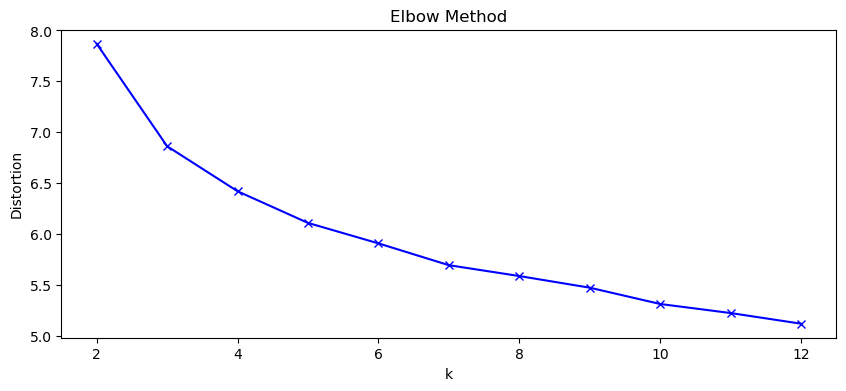

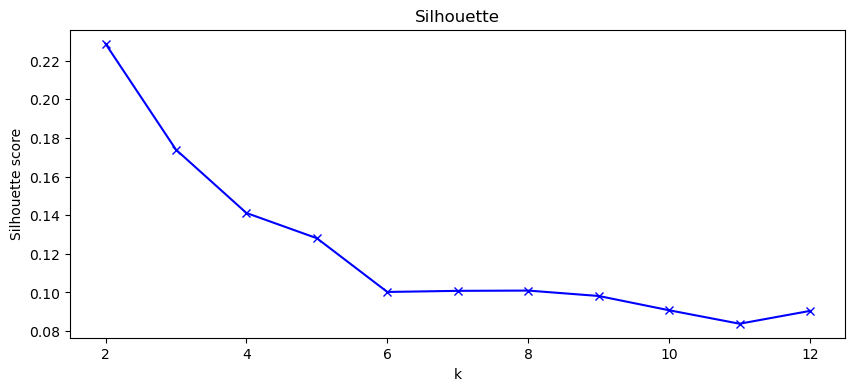

In [65]:
plot_scores(X_scaled)

  0%|          | 0/11 [00:00<?, ?it/s]

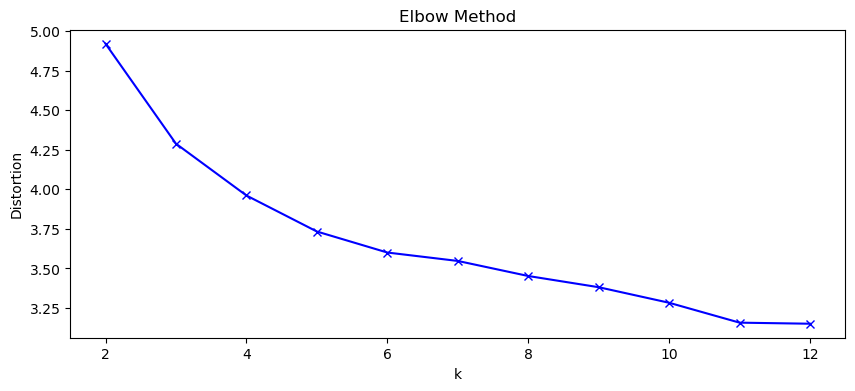

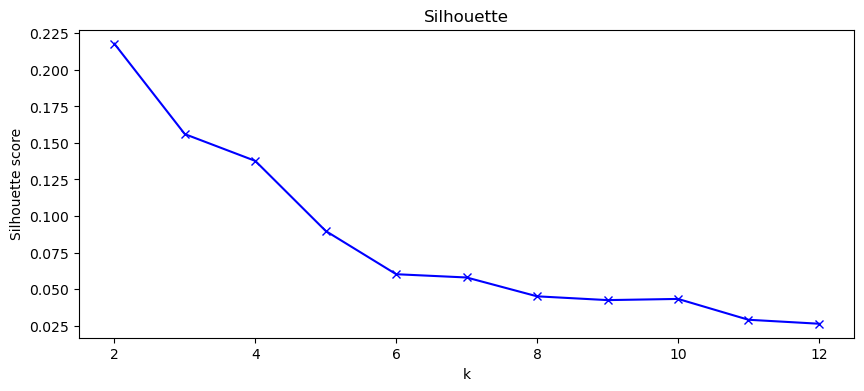

In [66]:
plot_scores(X_scaled, metric_name='dtw')

  0%|          | 0/3 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2


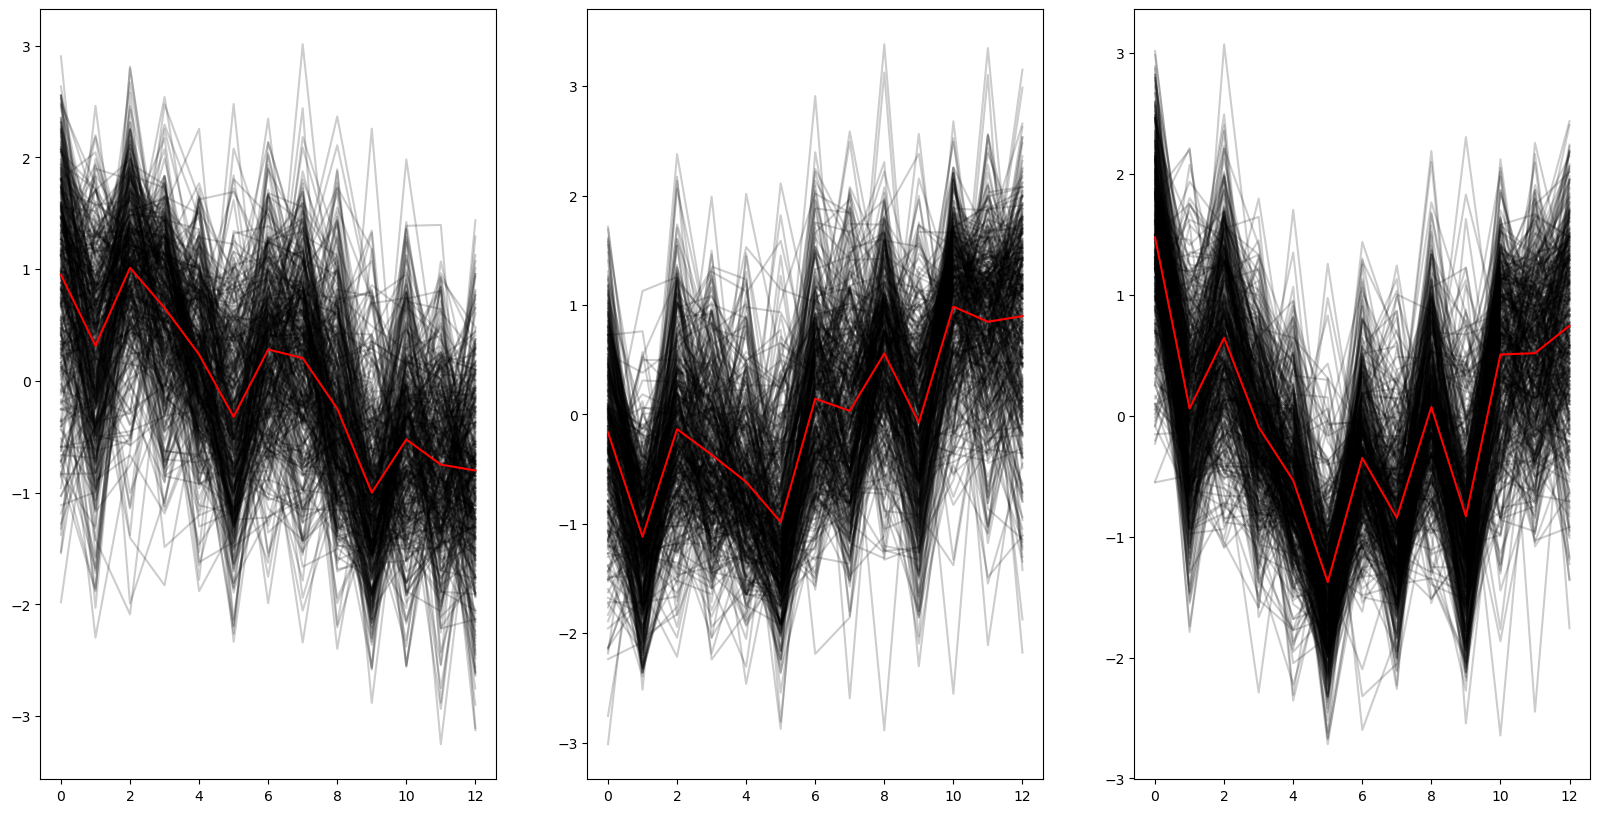

  0%|          | 0/4 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2
Cluster 3


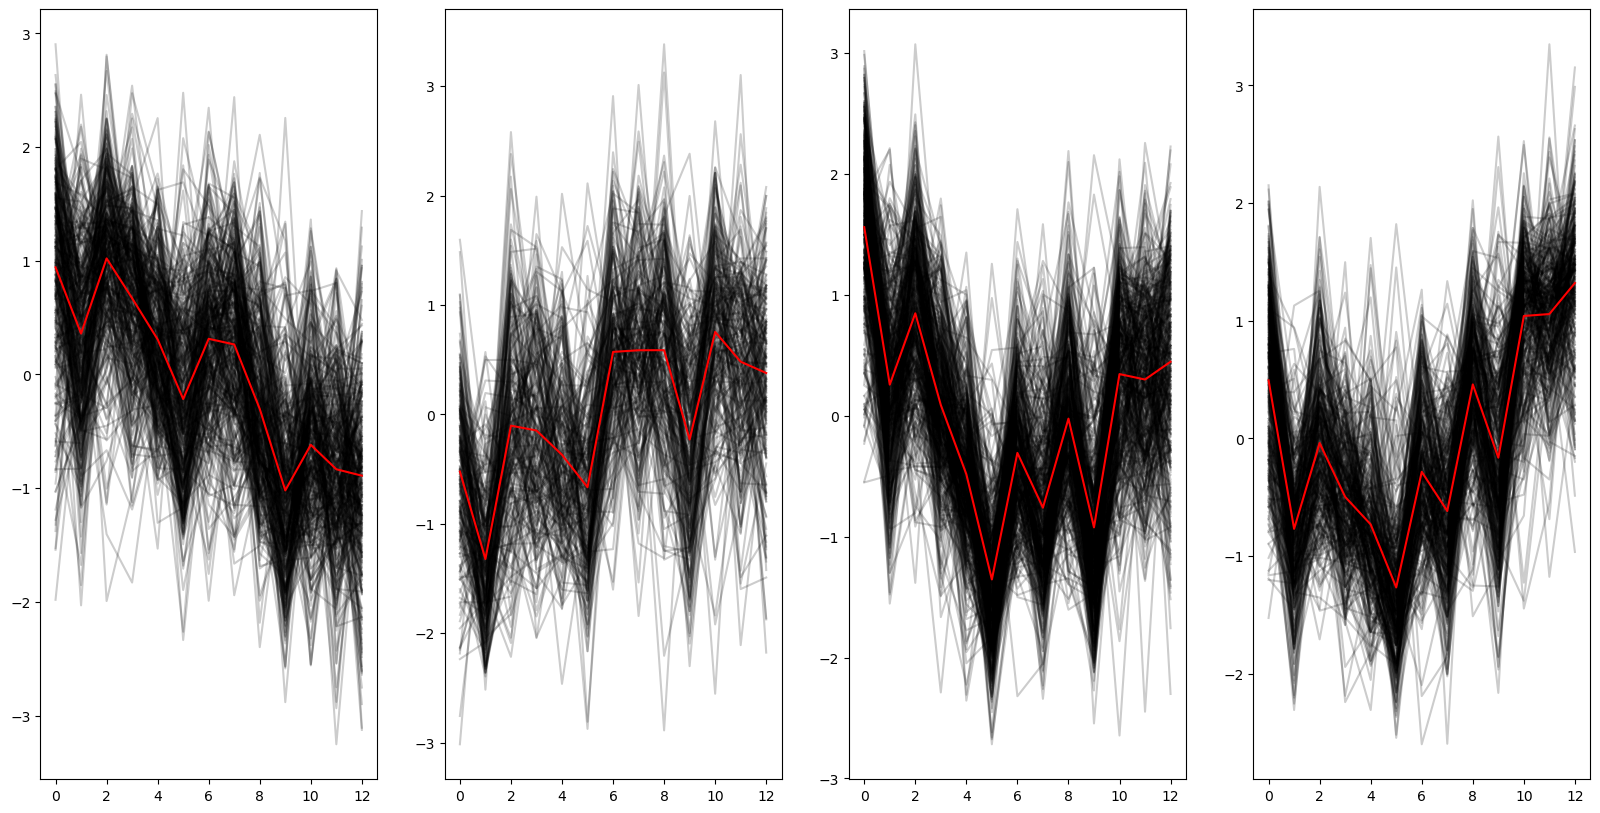

  0%|          | 0/6 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5


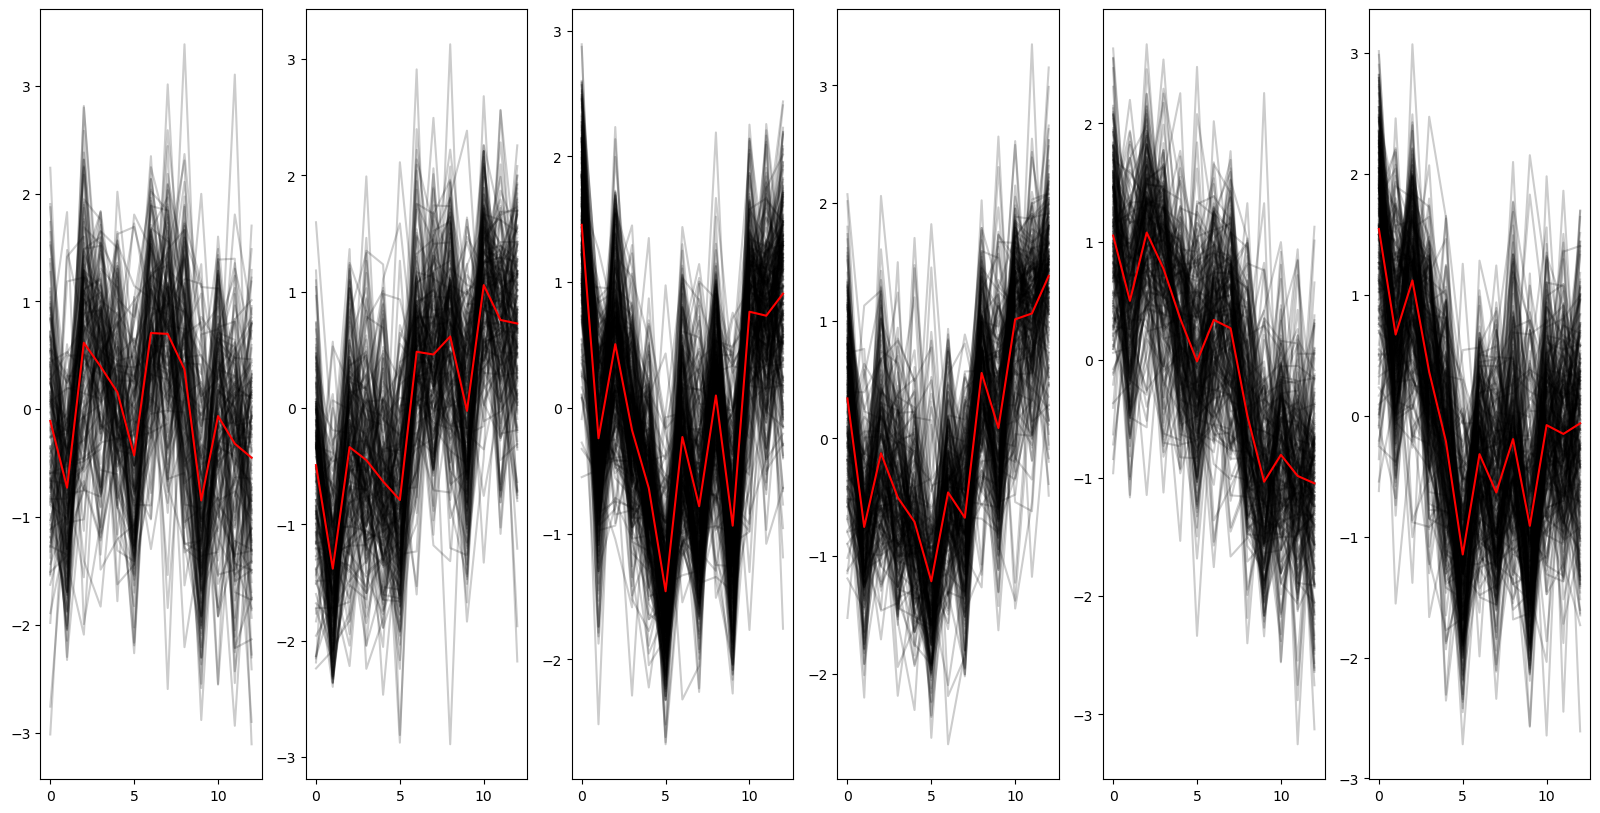

  0%|          | 0/3 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2


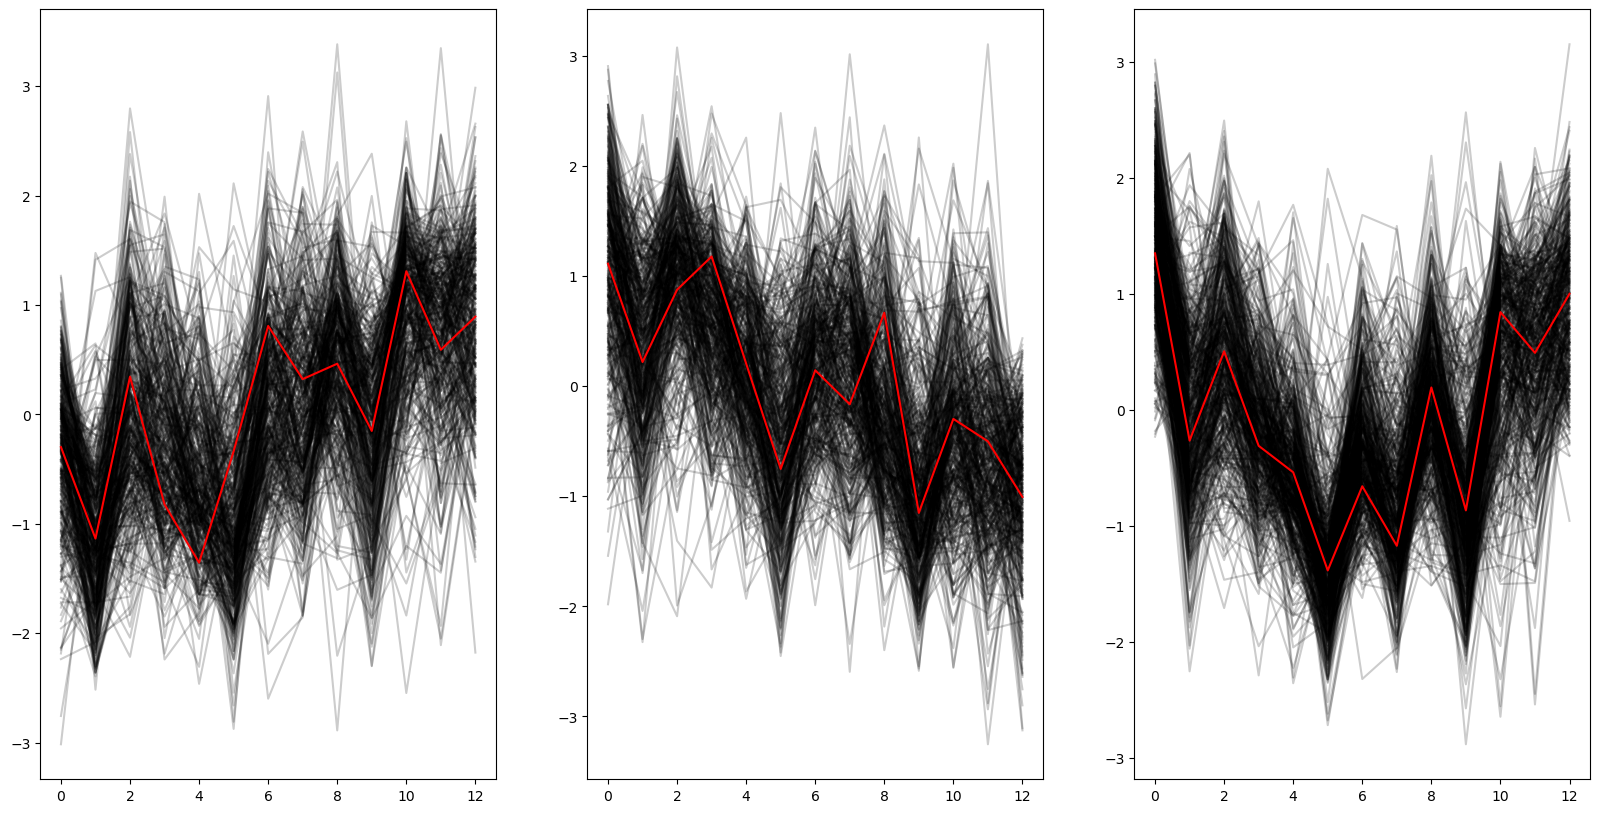

  0%|          | 0/4 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2
Cluster 3


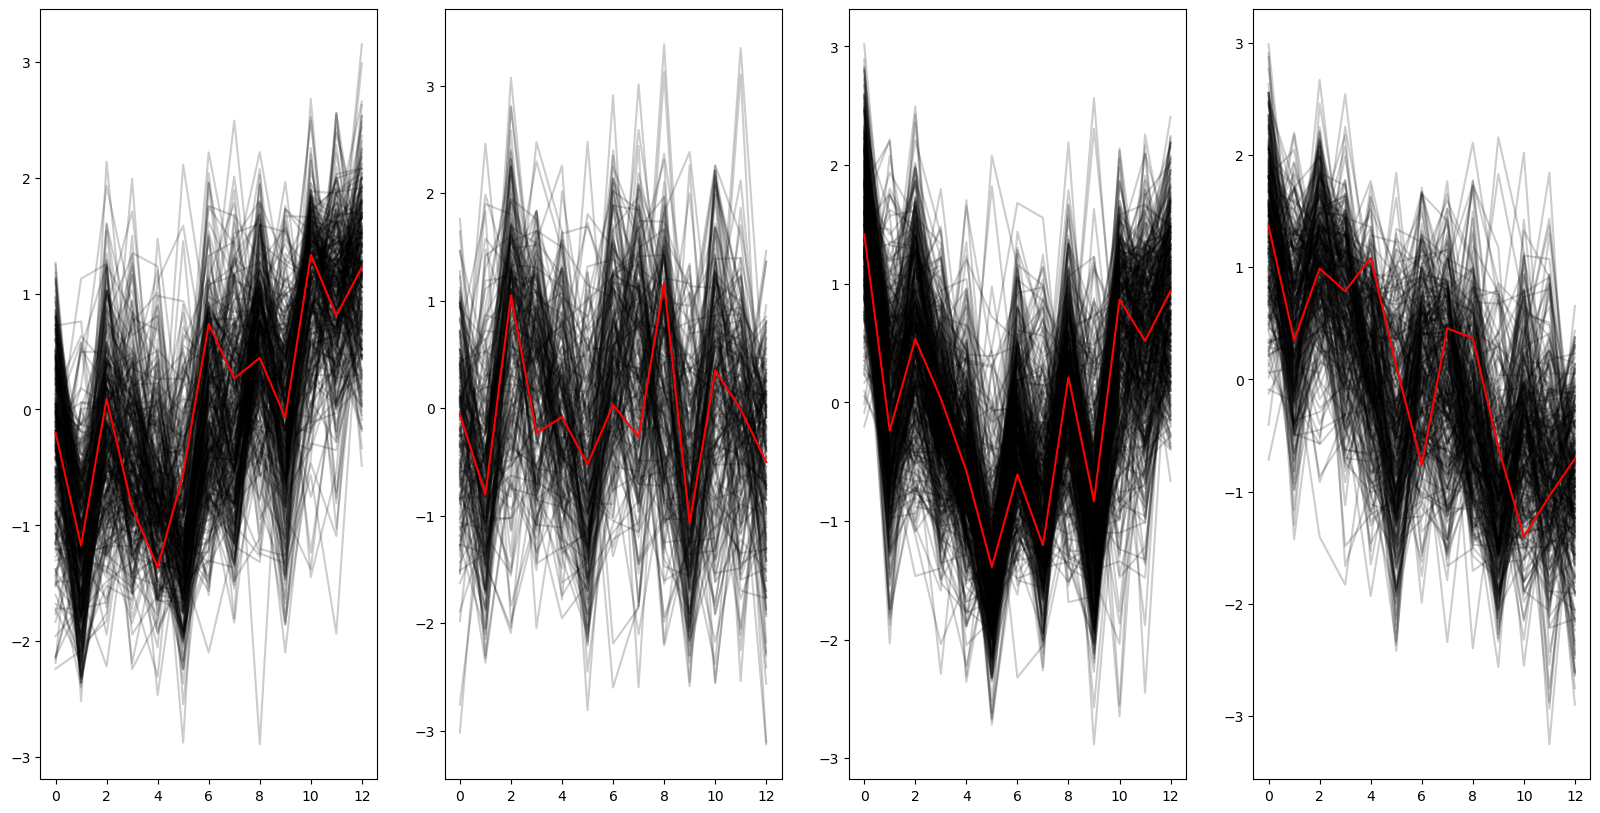

  0%|          | 0/6 [00:00<?, ?it/s]

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5


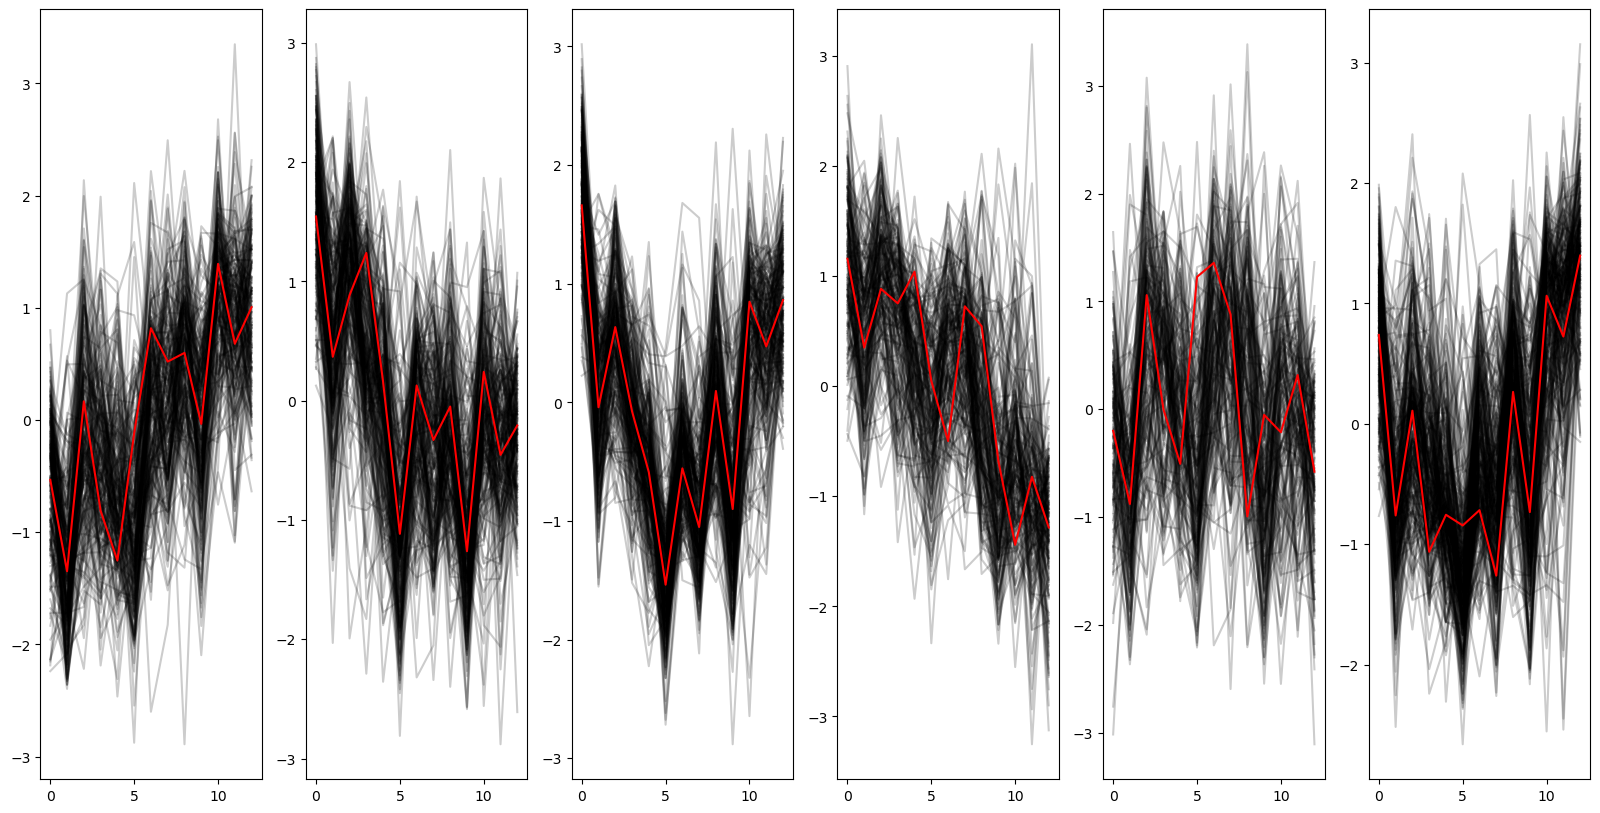

In [67]:
y_pred_3_euc = predict_y(X_scaled, 3) 
y_pred_4_euc = predict_y(X_scaled, 4) 
y_pred_6_euc = predict_y(X_scaled, 6) 
y_pred_3_dtw = predict_y(X_scaled, 3, metric_name='dtw') 
y_pred_4_dtw = predict_y(X_scaled, 4, metric_name='dtw') 
y_pred_6_dtw = predict_y(X_scaled, 6, metric_name='dtw') 

In [68]:
X_sales_processed["y_pred_3_euc"] = y_pred_3_euc 
X_sales_processed["y_pred_4_euc"] = y_pred_4_euc 
X_sales_processed["y_pred_6_euc"] = y_pred_6_euc 
X_sales_processed["y_pred_3_dtw"] = y_pred_3_dtw 
X_sales_processed["y_pred_4_dtw"] = y_pred_4_dtw 
X_sales_processed["y_pred_6_dtw"] = y_pred_6_dtw 

In [69]:
X_sales_processed.reset_index(inplace=True)

In [70]:
X_sales_processed.to_csv('data/상권_clusters.csv', encoding='cp949', index=False)